# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [21]:
import os
import sys
import json
import time
import random
import numpy as np
import fastjet
import awkward as ak
import vector
vector.register_awkward()
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import hist, processor
from hist import Hist
import matplotlib
sys.path.append("..")
from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report
from workflows.SUEP_coffea import SUEP_cluster
from plotting.plot_utils import plot_ratio, rebin_piecewise
import warnings
warnings.filterwarnings('ignore')

In [2]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

We set up a coffea ABC Processor to analyze the ROOT files.

In [3]:
class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str, scouting: int) -> None:
        
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample
        self.scouting = scouting

        self._accumulator = processor.dict_accumulator(
            {
                # cutflows
                "sumw": processor.defaultdict_accumulator(float),
                "total": processor.defaultdict_accumulator(float),
                "cut1": processor.defaultdict_accumulator(float),
                "cut2": processor.defaultdict_accumulator(float),
                "cut3": processor.defaultdict_accumulator(float),
                "cut4": processor.defaultdict_accumulator(float),
                "cut5": processor.defaultdict_accumulator(float),
                
                # histograms
                "ht_ak4": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_ak4", r"$H_T$ [GeV]", 500,0,5000),
                ),
                "dz_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dz", r"dz", 10000,0,50),
                ),
                "dz": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dz", r"dz", 10000,0,50),
                ),
                "dzerr_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dzerr", r"dzerr", 10000,0,1),
                ),
                "dzerr": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dzerr", r"dzerr", 10000,0,1),
                ),
                "dxy_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dxy", r"dxy", 10000,0,50),
                ),
                "dxy": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dxy", r"dxy", 10000,0,50),
                ),
                "dxyerr_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dxyerr", r"dxyerr", 10000,0,50),
                ),
                "dxyerr": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("dxyerr", r"dxyerr", 10000,0,50),
                ),
                "trkQuality_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("trkQuality", r"trkQuality", 1000,0,50),
                ),
                "trkQuality": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("trkQuality", r"trkQuality", 1000,0,50),
                ),
                "pvAssocQuality_fromPV": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("pvAssocQuality", r"pvAssocQuality", 1000,0,50),
                ),
                "pvAssocQuality": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("pvAssocQuality", r"pvAssocQuality", 1000,0,50),
                ),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def getak4jets(self, events):
        if self.scouting == 1:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
            })
        else:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
                "jetId": events.Jet.jetId
            })
        jetCut = (Jets.pt > 30) & (abs(Jets.eta)<2.4)
        ak4jets = Jets[jetCut]
        return ak4jets
    
    # this is modified from the normal SUEP_cluster one,
    # since we need to count events after each selection
    def eventSelection(self, events, output, dataset):
        
        ak4jets = self.getak4jets(events)
        
        ht = ak.sum(ak4jets.pt,axis=-1)
        output['ht_ak4'].fill(ht_ak4=ht, dataset=dataset)
        
        # apply trigger selection
        if self.scouting == 1:
            events = events[(ht > 600)]
            ak4jets = ak4jets[(ht > 600)]
        else:
            if self.era == 2016:
                trigger = events.HLT.PFHT900 == 1
            else:
                trigger = events.HLT.PFHT1050 == 1

            events = events[(trigger)]
            ak4jets = ak4jets[(trigger)]
            ht = ht[(trigger)]

            output["cut1"][dataset] += len(events)

            events = events[(ht > 1200)]
            ak4jets = ak4jets[(ht > 1200)]

            output["cut2"][dataset] += len(events)
            
        return events, ak4jets

    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']
                
        # this needs to be here!
        # FIXME: why isn't doing this in __init__ enough?
        vector.register_awkward()

        if self.isMC: self.gensumweight = ak.sum(events.genWeight)
        
        output["sumw"][dataset] += ak.sum(events.genWeight)
        output["total"][dataset] += len(events)
        
        events, ak4jets = self.eventSelection(events, output, dataset)
    
        if len(events) == 0:
            return output
    
        basicSel =  (events.PFCands.trkPt >= 0.75) & (abs(events.PFCands.trkEta) <= 2.5)
        
        dz = events.PFCands.dz[basicSel]
        dzerr = events.PFCands.dzErr[basicSel]
        dxy = events.PFCands.d0[basicSel]
        dxyerr = events.PFCands.d0Err[basicSel]
        pvAssocQuality = events.PFCands.pvAssocQuality[basicSel]
        trkQuality = events.PFCands.trkQuality[basicSel]
        
        fromPV = (events.PFCands.fromPV[basicSel] > 1)
        
        dz_fromPV = dz[fromPV]
        dzerr_fromPV = dzerr[fromPV]
        dxyerr_fromPV = dxyerr[fromPV]
        dxy_fromPV = dxy[fromPV]
        pvAssocQuality_fromPV = pvAssocQuality[fromPV]
        trkQuality_fromPV = trkQuality[fromPV]
                
        for iEvent in range(len(dz)):
            
            if iEvent > 100: break
            
            output['dz'].fill(dz=ak.to_numpy(dz[iEvent]), dataset=dataset)
            output['dzerr'].fill(dzerr=ak.to_numpy(dzerr[iEvent]), dataset=dataset)
            output['dxy'].fill(dxy=ak.to_numpy(dxy[iEvent]), dataset=dataset)
            output['dxyerr'].fill(dxyerr=ak.to_numpy(dxyerr[iEvent]), dataset=dataset)
            output['pvAssocQuality'].fill(pvAssocQuality=ak.to_numpy(pvAssocQuality[iEvent]), dataset=dataset)
            output['trkQuality'].fill(trkQuality=ak.to_numpy(trkQuality[iEvent]), dataset=dataset)
            
            output['dz_fromPV'].fill(dz=ak.to_numpy(dz_fromPV[iEvent]), dataset=dataset)
            output['dzerr_fromPV'].fill(dzerr=ak.to_numpy(dzerr_fromPV[iEvent]), dataset=dataset)
            output['dxy_fromPV'].fill(dxy=ak.to_numpy(dxy_fromPV[iEvent]), dataset=dataset)
            output['dxyerr_fromPV'].fill(dxyerr=ak.to_numpy(dxyerr_fromPV[iEvent]), dataset=dataset)
            output['pvAssocQuality_fromPV'].fill(pvAssocQuality=ak.to_numpy(pvAssocQuality_fromPV[iEvent]), dataset=dataset)
            output['trkQuality_fromPV'].fill(trkQuality=ak.to_numpy(trkQuality_fromPV[iEvent]), dataset=dataset)
    
        return output
    
    def postprocess(self, accumulator):
        return accumulator

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.iEvent

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate SUEP',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u210253',
     'export PYTHONPATH=/home/submit/lavezzo/SUEP/SUEPCoffea_dask/:/home/submit/lavezzo/SUEP/SUEPCoffea_dask/workflows/:$PYTHONPATH'
     # 'sleep $[ ( $RANDOM % 1000 )  + 1 ]s'
]

extra_args=[
     "--output=logs/dask_job_output_%j.out",
     "--error=logs/dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6821                   # might need to change this if re running
w_port       = 9766
cores        = 2
processes    = 2
memory       = "2 GB"

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
# load samples
file = "../filelist/list_2018_SUEP_A01.txt"
samples = []
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)
        
file = "../filelist/list_2018_HT_A01.txt"
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)

In [7]:
# load file names
samples_dict = {}
for sample_name in samples:
    
    input_list = "/home/tier3/cmsprod/catalog/t2mit/nanosu/A01/{}/RawFiles.00".format(sample_name)
    
    files = []
    Raw_list = open(input_list, "r")
    for i in Raw_list:
        file = i.split(" ")[0]
        files.append(file)
    
    samples_dict[sample_name] = files

In [12]:
from plotting import fill_utils
# cross section
xsections = {}
for sample in list(samples_dict.keys()):
    
    if 'QCD_HT' in sample: 
        xsection = fill_utils.getXSection(sample, '2018')
        sample_name = sample.split('QCD_HT')[1].split("_Tune")[0]
    elif 'SUEP' in sample:
        xsection = fill_utils.getXSection(sample, '2018', SUEP=True)
        sample_name = sample.split("+")[0]
    else:
        xsection = fill_utils.getXSection(sample, '2018')
        sample_name = sample
    xsections.update({sample_name:xsection})

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [9]:
while not check_port(n_port):
    time.sleep(5)
    n_port+=1

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 2906,
              'host': socket.gethostname()
        },
    
        job_extra=extra_args,
        env_extra=slurm_env,
)

In [10]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.2:6821' processes=0 threads=0, memory=0 B>


## Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [14]:
run_dict = {}

# select only some of the SUEP masses
template = 'SUEP-m{}-{}+RunIIAutumn18-private+MINIAODSIM'
for m in ['125', '400', '750', '1000']:
    decay = 'generic'
    if m == '125': decay+="-htcut"
    key = template.format(m, decay)
    new_key = key.split('+')[0]
    run_dict.update({new_key:samples_dict[key]})
    
percent = 0.01
for sample in samples:
    if 'QCD_HT' not in sample: continue
    new_key = sample.split('QCD_HT')[1].split("_Tune")[0]
    QCD_bin = samples_dict[sample]
    nfiles = int(percent * len(QCD_bin))
    #run_dict.update({new_key:QCD_bin[:2]})

In [12]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(run_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           'skipbadfiles': True,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 30,
                           'retries': 4,
                           },
             chunksize=100000)

[                                        ] | 0% Completed |  5min  2.1s

2022-12-05 11:20:56,363 - distributed.core - ERROR - Exception while handling op performance_report
Traceback (most recent call last):
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/distributed/core.py", line 558, in handle_comm
    result = await result
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/distributed/scheduler.py", line 7824, in performance_report
    from distributed.dashboard.components.scheduler import task_stream_figure
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 13, in <module>
    from bokeh.models import (
ImportError: cannot import name 'Panel' from 'bokeh.models' (/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/bokeh/models/__init__.py)


ImportError: cannot import name 'Panel' from 'bokeh.models' (/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/bokeh/models/__init__.py)

For testing, an iterative local executor

In [16]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)
output = processor.run_uproot_job(run_dict,
         treename='Events',
         processor_instance=processor_instance,
         executor=processor.futures_executor,
         executor_args={
                        'workers': 20,
                        'skipbadfiles': True,
                        'schema': processor.NanoAODSchema,
                        'xrootdtimeout': 120,
                       },
         chunksize=10000000)

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634/634 [ 0:02:23 < 0:00:00 | 0.0  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634/634 [ 0:02:23 < 0:00:00 | ?   merges/s ]

In [13]:
client.cancel(cluster)

In [18]:
output
coffea.util.save(output, "unscaled_SUEP-12-5.coffea")

In [28]:
# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    xsec = xsections[dataset]
    scale = xsec / output["sumw"][dataset]
    scale = 1 # FIXME: manual overwrite, for now
    scales.update({dataset: scale})

# apply normalization to all histograms
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    if type(output[key]) == coffea.processor.accumulator.defaultdict_accumulator:
        continue
    output[key].scale(scales, axis='dataset')

coffea.util.save(output, "SUEP_output_v4.coffea")

total
cut1
cut2
cut3
cut4
cut5
ht_ak4
dz_fromPV
dz
dzerr_fromPV
dzerr
dxy_fromPV
dxy
dxyerr_fromPV
dxyerr
trkQuality_fromPV
trkQuality
pvAssocQuality_fromPV
pvAssocQuality


In [29]:
qcd_output = coffea.util.load("QCD_output_v3.coffea")
suep_output = coffea.util.load("SUEP_output_v4.coffea")

In [26]:
import matplotlib.pyplot as plt
from coffea.hist import plot
import mplhep as hep
from hist import intervals, Hist, storage, axis

from plotting.plot_utils import rebin_piecewise

outDir = '/home/submit/lavezzo/public_html/SUEP/track_selection/rebinned/{}'

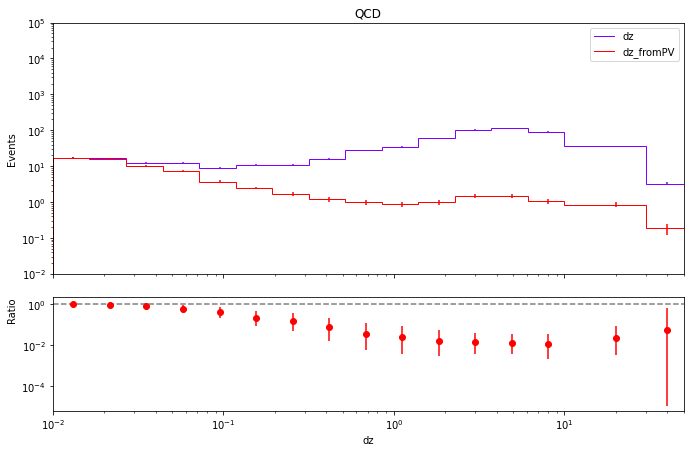

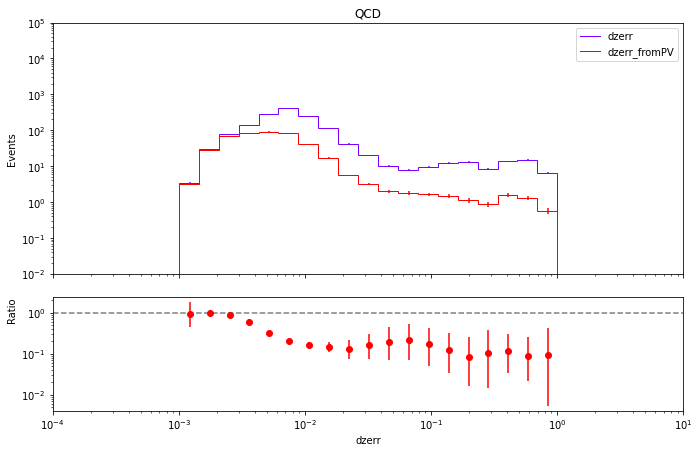

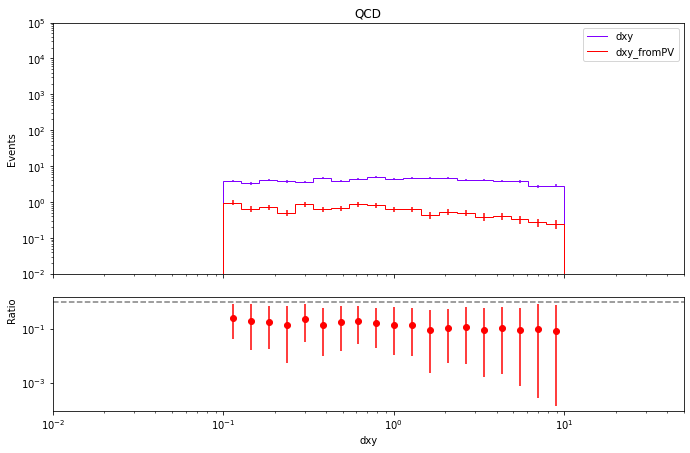

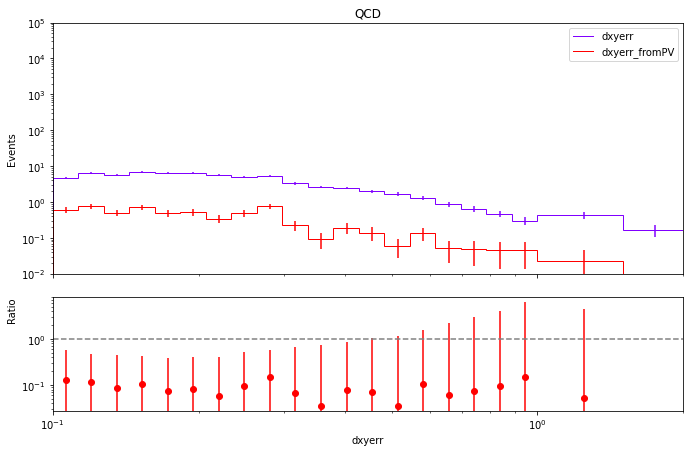

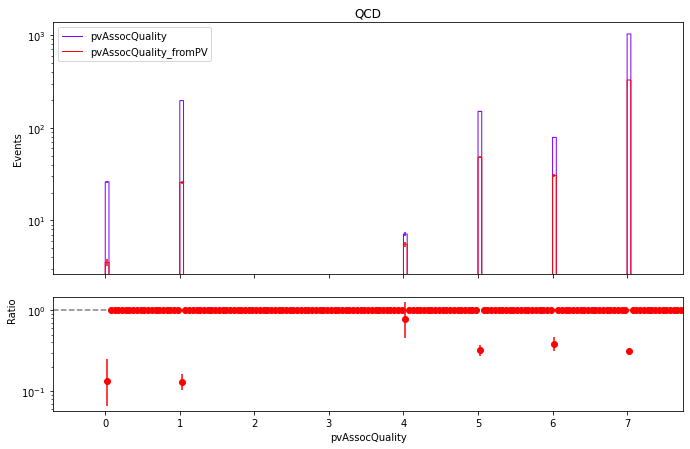

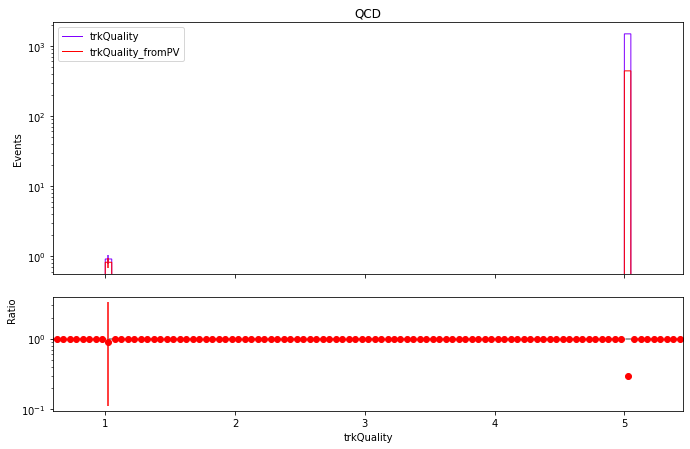

In [68]:
# QCD: Combine HT bins

plot_labels = ['dz','dzerr','dxy','dxyerr','pvAssocQuality','trkQuality'] 
plots = qcd_output

for plot_label in plot_labels:
    h_all = plots[plot_label].to_hist()
    for iSample in range(h_all.shape[0]):
        h = h_all[iSample,:]         
        if iSample == 0: h_tot = h
        else: h_tot += h
        
    h_all_2 = plots[plot_label+'_fromPV'].to_hist()
    for iSample in range(h_all_2.shape[0]):
        h = h_all_2[iSample,:]         
        if iSample == 0: h_tot_2 = h
        else: h_tot_2 += h
        
    if plot_label in ['dz']: 
        new_bins = np.concatenate((np.logspace(-2,1,15),[30,50])) 
    elif plot_label in ['dxy']:
        new_bins = np.logspace(-1,1,num=20)
    elif plot_label in ['dzerr']: 
        new_bins = np.logspace(-3,0,num=20)
    elif plot_label in ['dxyerr']:
        new_bins = np.concatenate((np.logspace(-1,0,num=20),[1.5, 2]))
    else: 
        new_bins = None
    
    if new_bins is not None:
        h_tot = rebin_piecewise(h_tot, new_bins)
        h_tot_2 = rebin_piecewise(h_tot_2, new_bins)

    # elif plot_label in ['dxyerr']: 
    #     new_bins = np.logspace(-2,0,num=5)
    #     h_tot = rebin_piecewise(h_tot, new_bins)
    #     h_tot_2 = rebin_piecewise(h_tot_2, new_bins)
        
    fig, ax = plot_ratio([h_tot, h_tot_2], [plot_label, plot_label+'_fromPV'])
    _ = ax[0].set_title('QCD')
    _ = ax[0].set_yscale('log')
    _ = ax[0].set_ylabel("Events")
    _ = ax[1].set_yscale('log')
    
    if new_bins is not None:
        _ = ax[0].set_xscale('log')

    if plot_label == 'dz' or plot_label == 'dxy':
        _ = ax[0].set_xlim(1e-2,5e1)
        _ = ax[0].set_ylim(1e-2,1e5)  
    elif plot_label == 'dzerr':
        _ = ax[0].set_xlim(1e-4,1e1)
        _ = ax[0].set_ylim(1e-2,1e5)
    elif plot_label ==  'dxyerr':
        _ = ax[0].set_xlim(1e-1,2e0)
        _ = ax[0].set_ylim(1e-2,1e5)
        
    plt.savefig(outDir.format('QCD ' + plot_label + '.pdf'), dpi=100)
    plt.savefig(outDir.format('QCD ' + plot_label + '.png'), dpi=100)

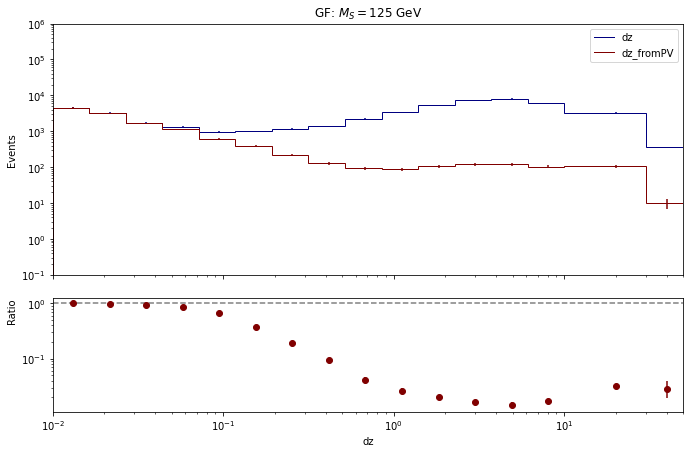

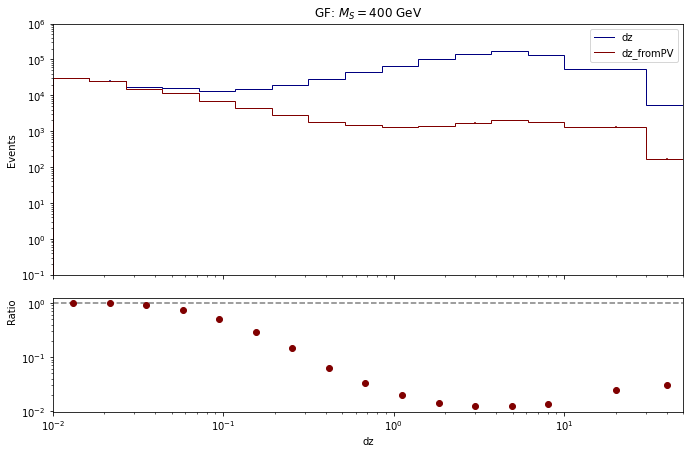

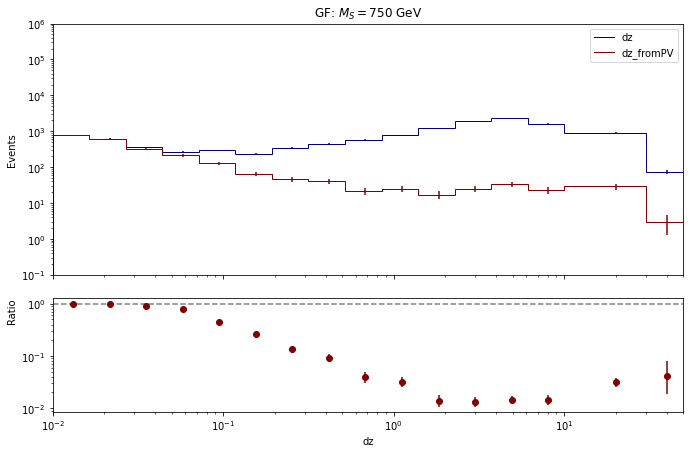

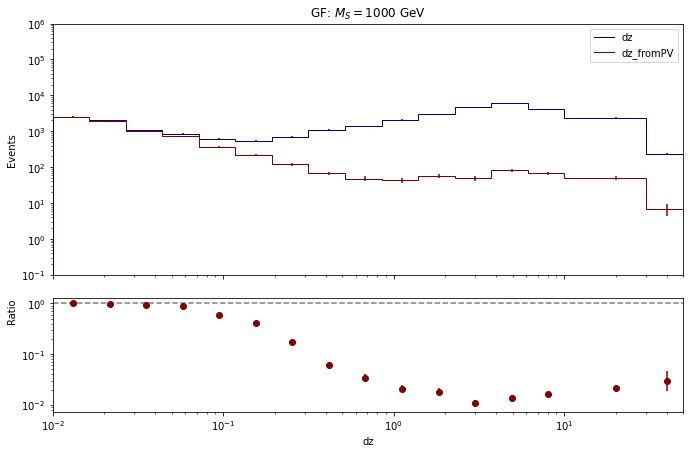

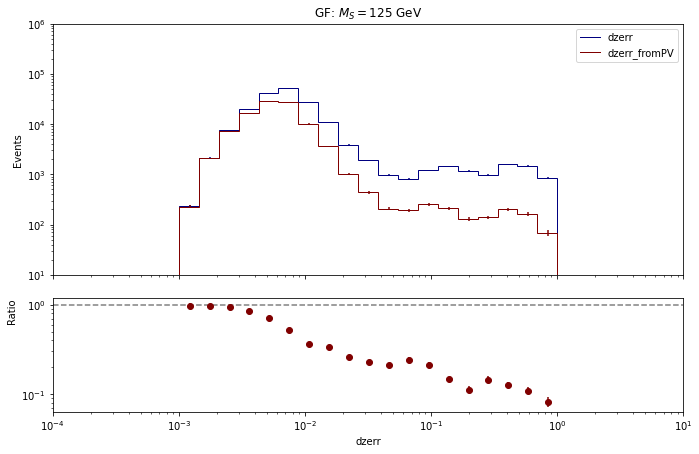

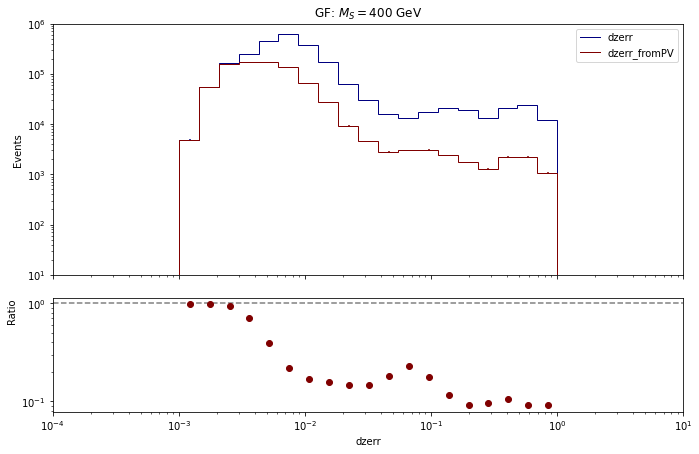

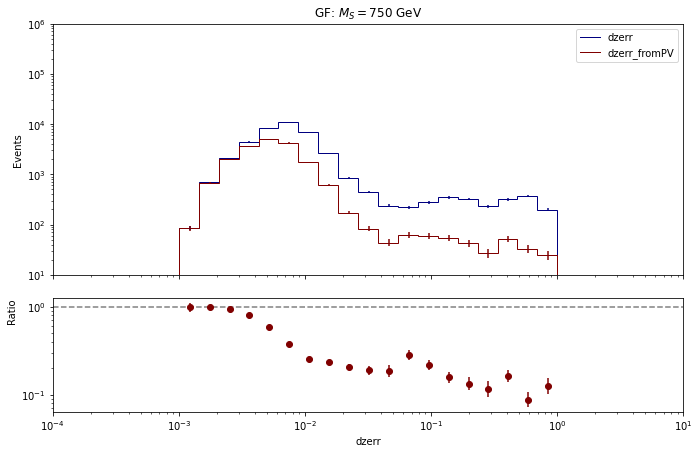

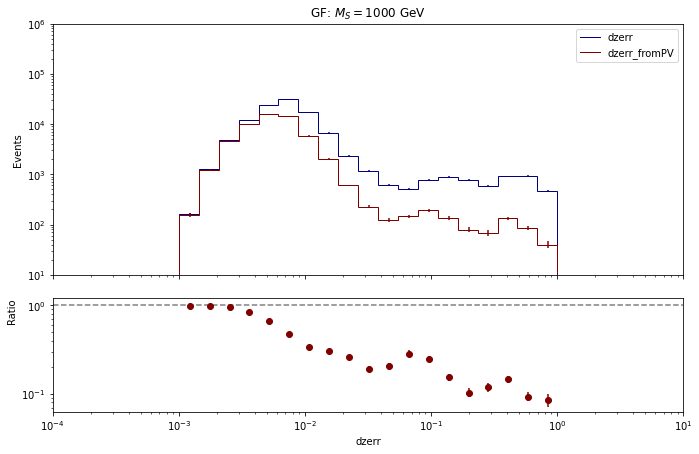

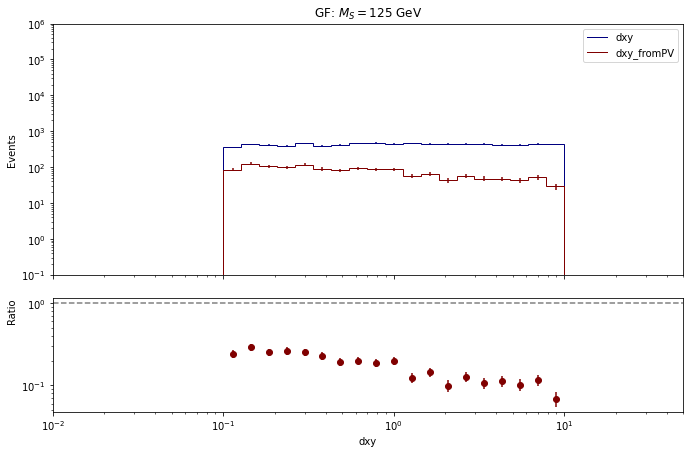

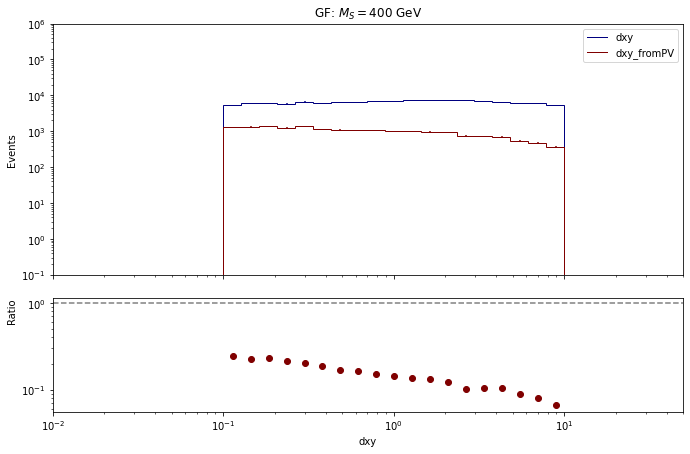

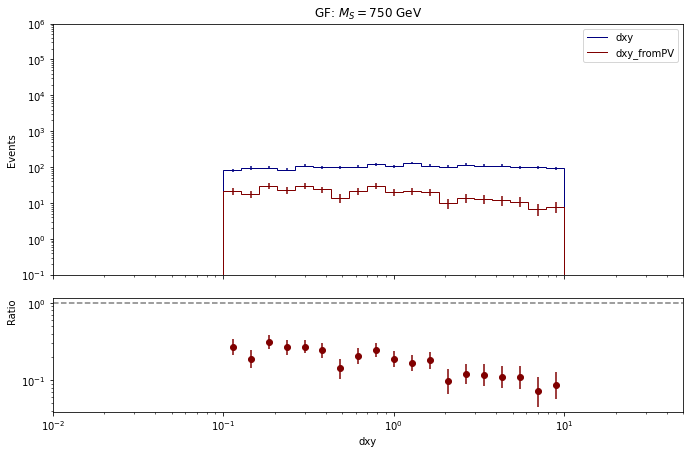

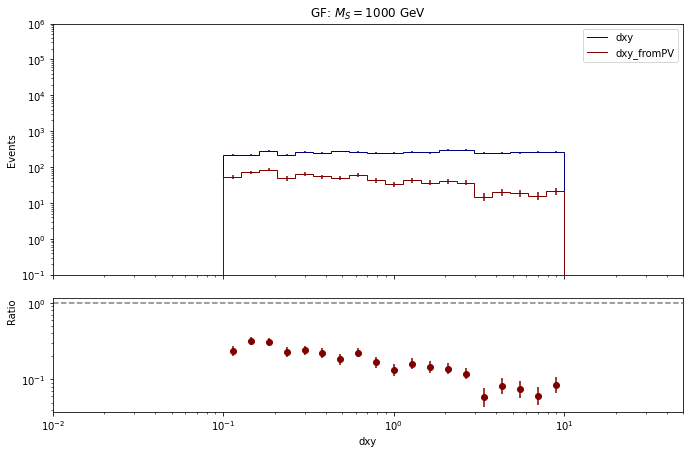

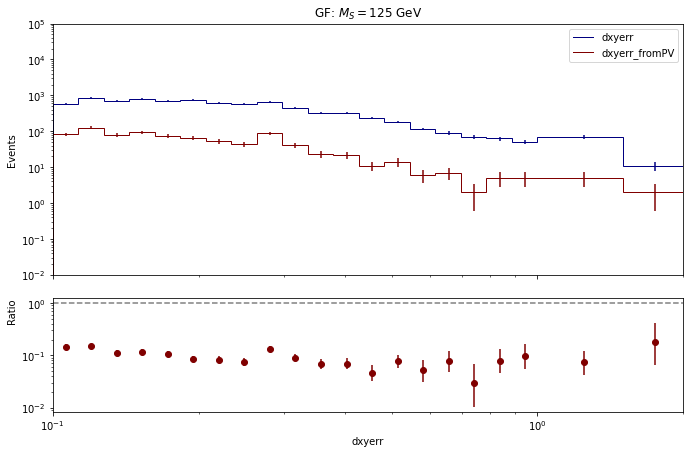

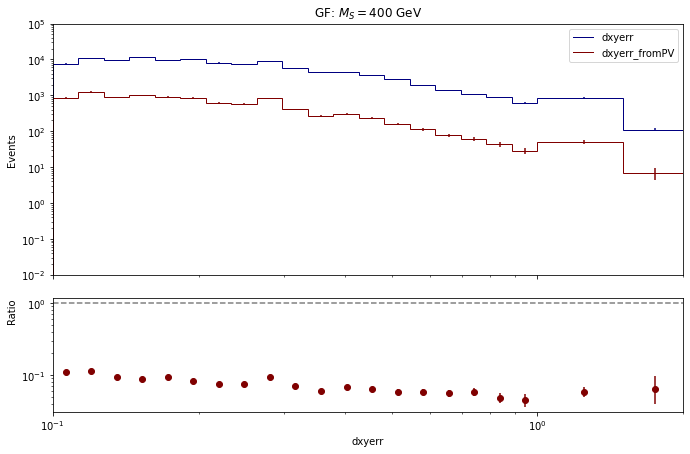

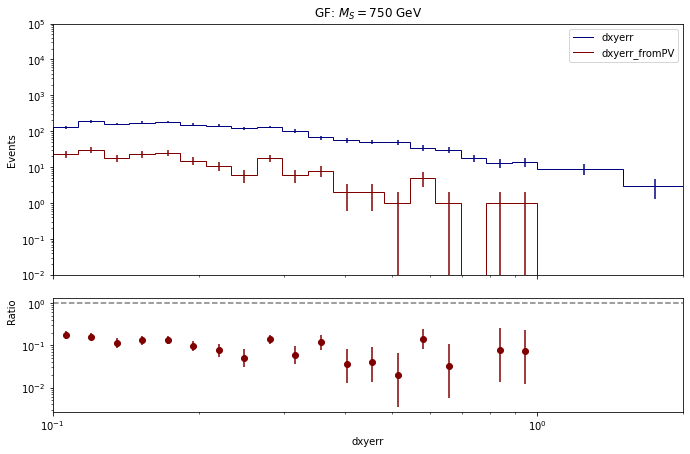

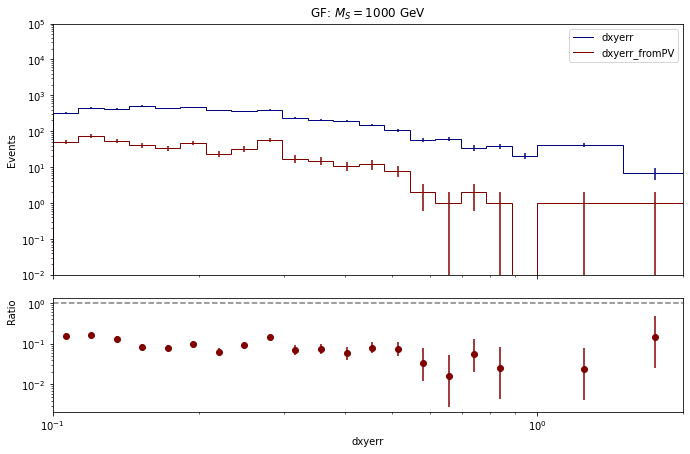

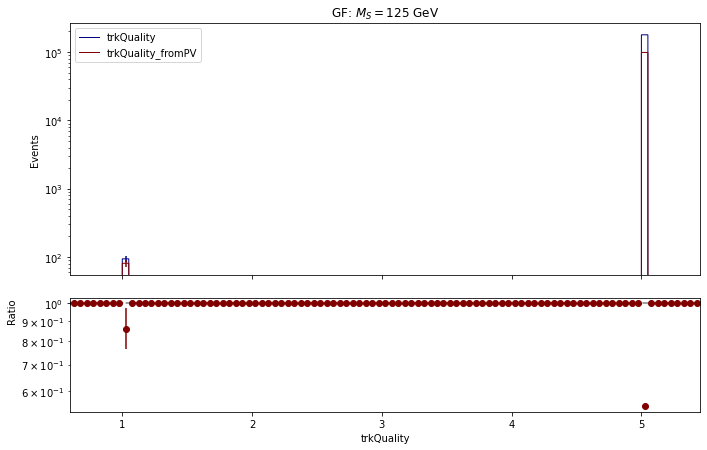

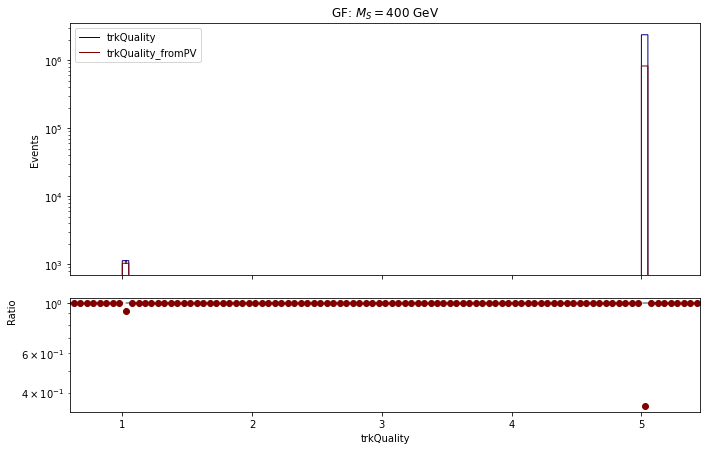

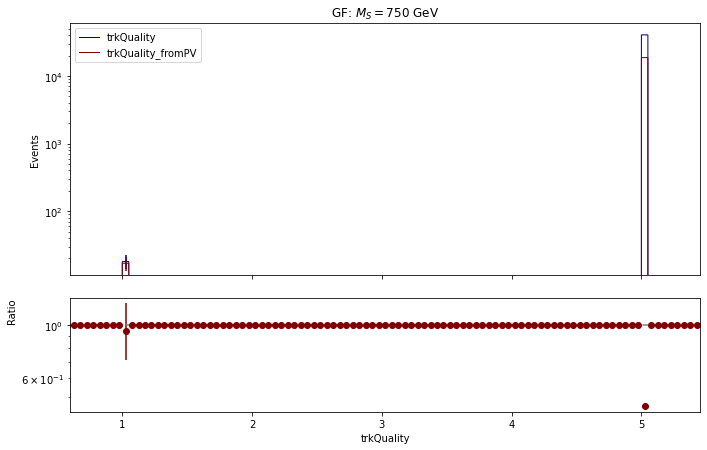

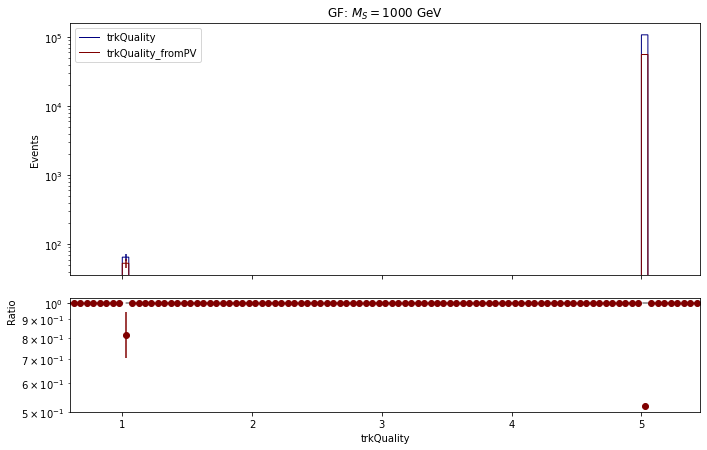

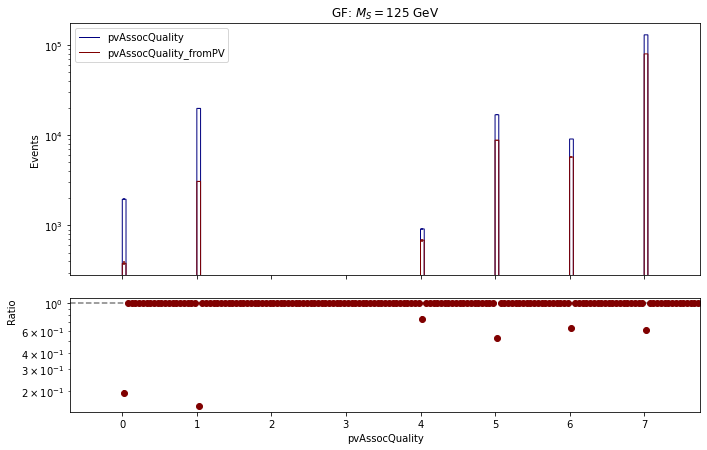

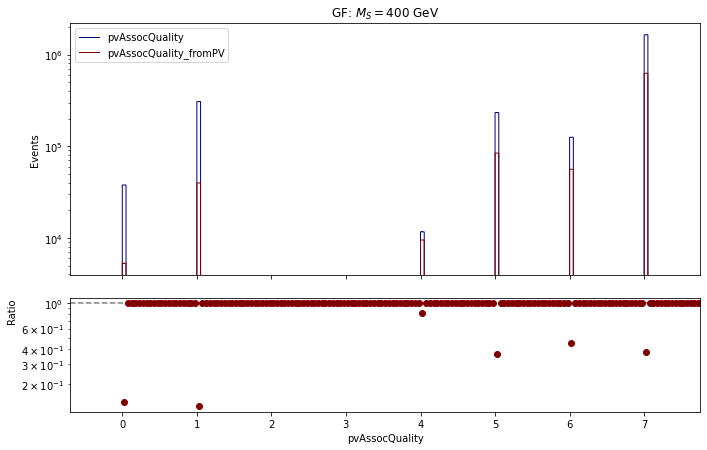

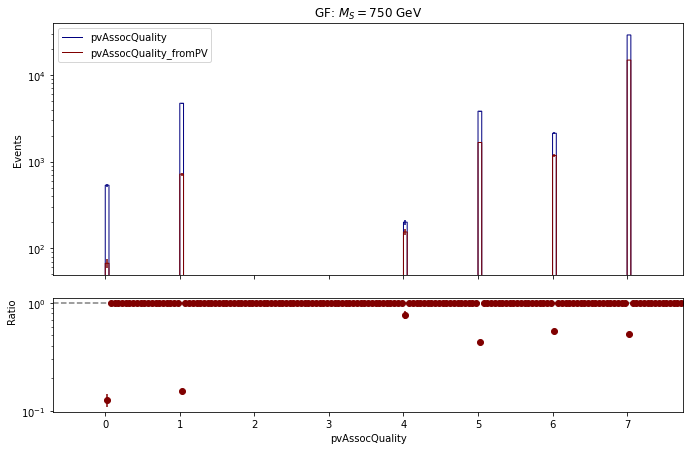

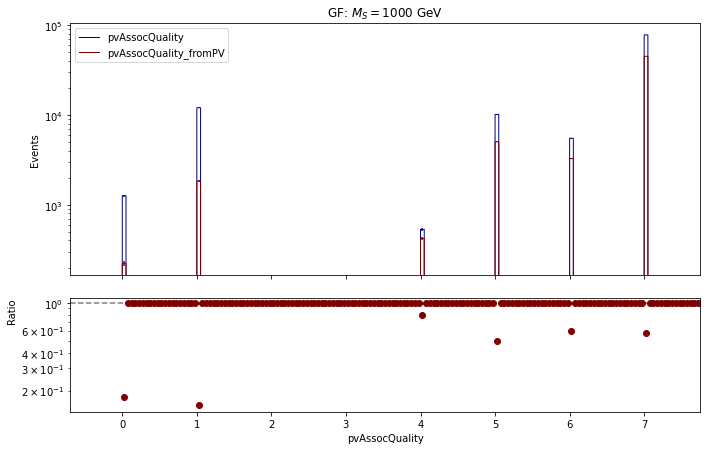

In [39]:
# SUEP: plot samples separately

labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]
order = ['SUEP-m125-generic-htcut','SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
plot_labels = ['dz', 'dzerr', 'dxy', 'dxyerr', 'trkQuality', 'pvAssocQuality']
plots = output

for plot_label in plot_labels:
    
    for iSample in range(plots[plot_label].to_hist().shape[0]):

        h1 = plots[plot_label].to_hist()[iSample,:]
        h2 = plots[plot_label+'_fromPV'].to_hist()[iSample,:]
        
        if plot_label in ['dz']: 
            new_bins = np.concatenate((np.logspace(-2,1,15),[30,50])) 
        elif plot_label in ['dxy']:
            new_bins = np.logspace(-1,1,num=20)
        elif plot_label in ['dzerr']: 
            new_bins = np.logspace(-3,0,num=20)
        elif plot_label in ['dxyerr']:
            new_bins = np.concatenate((np.logspace(-1,0,num=20),[1.5, 2]))
        else: 
            new_bins = None
    
        if new_bins is not None:
            try:
                h1 = rebin_piecewise(h1, new_bins)
                h2 = rebin_piecewise(h2, new_bins)
            except:
                print(h1.sum(), h2.sum())
                break
        
        # h1 = h1/h1.sum().value
        # h2 = h2/h2.sum().value
        
        fig, ax = plot_ratio([h1, h2], [plot_label, plot_label+'_fromPV'])
        _ = ax[0].set_title(labels[iSample])
        _ = ax[0].set_yscale('log')
        _ = ax[0].set_ylabel("Events")
        _ = ax[1].set_yscale('log')

        if new_bins is not None:
            _ = ax[0].set_xscale('log')

        if plot_label == 'dz' or plot_label == 'dxy':
            _ = ax[0].set_xlim(1e-2,5e1)
            _ = ax[0].set_ylim(1e-1,1e6)  
        elif plot_label == 'dzerr':
            _ = ax[0].set_xlim(1e-4,1e1)
            _ = ax[0].set_ylim(1e1,1e6)
        elif plot_label ==  'dxyerr':
            _ = ax[0].set_xlim(1e-1,2e0)
            _ = ax[0].set_ylim(1e-2,1e5)

        plt.savefig(outDir.format(order[iSample] + plot_label + '.pdf'), dpi=100)
        plt.savefig(outDir.format(order[iSample] + plot_label + '.png'), dpi=100)
        
        plt.show()